<a href="https://colab.research.google.com/github/Bio-MingChen/DL_practice_by_Colab/blob/main/Raman2single_cell_refinement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
from IPython.display import clear_output

# Call clear_output() to clear the output of the current cell
! pip install scanpy scikit-learn scikit-misc
clear_output()

In [100]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [101]:
import os
import sys
sys.path.extend([".", ".."])

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils as U
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import scipy as sp
import pandas as pd

# -------------------------
# helpers
# -------------------------
def turn_on_model(model: nn.Module):
    for p in model.parameters():
        p.requires_grad = True

def turn_off_model(model: nn.Module):
    for p in model.parameters():
        p.requires_grad = False


# -------------------------
# Encoder / Decoder
# -------------------------
class StandardEncoder(nn.Module):
    """
    与原文相同的多层全连接 + BN + ReLU 堆叠，最后输出 mean / logvar。
    hidden_dim 默认 512，可改。
    """
    def __init__(self, input_dim: int, latent_dim: int, hidden_dim: int = 512):
        super().__init__()
        self.part1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),

            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),

            # extra block (保持与原文一致)
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),

            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),

            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
        )
        self.to_mean   = nn.Linear(hidden_dim, latent_dim)
        self.to_logvar = nn.Linear(hidden_dim, latent_dim)

        self.latent_dim = latent_dim

    def forward(self, x):
        h = self.part1(x)
        return self.to_mean(h), self.to_logvar(h)


class StandardDecoder(nn.Module):
    """
    与原文一致，区别仅在于用显式数字替代 1<<k。
    no_final_relu=True 时不做末层 ReLU（常用于重构原值回归）。
    """
    def __init__(self, input_dim: int, latent_dim: int, hidden_dim: int = 512, no_final_relu: bool = False):
        super().__init__()

        layers = [
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),

            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),

            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),

            # extra block
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),

            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),

            nn.Linear(hidden_dim, input_dim),
        ]
        if not no_final_relu:
            layers.append(nn.ReLU(inplace=True))

        self.net = nn.Sequential(*layers)
        self.latent_dim = latent_dim

    def forward(self, z):
        return self.net(z)


class Discriminator(nn.Module):
    """
    判别器与原文相同：可选 spectral norm，输出 end_dim=2 个 logits（源/目标 one-hot）。
    层宽 64 -> 32 -> 32 -> end_dim，均显式数字，不再用位移写法。
    """
    def __init__(self, latent_dim: int, spectral: bool = True, end_dim: int = 2):
        super().__init__()
        def linear(n_in, n_out):
            layer = nn.Linear(n_in, n_out)
            return U.spectral_norm(layer) if spectral else layer

        self.net = nn.Sequential(
            linear(latent_dim, 64),
            nn.ReLU(inplace=True),
            linear(64, 32),
            nn.ReLU(inplace=True),
            linear(32, 32),
            nn.ReLU(inplace=True),
            linear(32, end_dim),   # logits（不用 Sigmoid/Softmax，后面配 BCEWithLogits）
        )

    def forward(self, z):
        return self.net(z)


# -------------------------
# VAE wrapper
# -------------------------
class VAE(nn.Module):
    """
    与原逻辑保持一致：
      - is_vae=True 时用 reparam；False 则直接用 mean。
      - latent_norm: 'batch'（默认）或 'none'；原代码等价于一直做 BatchNorm。
      - forward: 先 reparam 再（可选）做 latent 归一化（去掉了原代码中永不触发的 if 0 分支）。
    """
    def __init__(
        self,
        encoder: nn.Module,
        decoder: nn.Module,
        is_vae: bool = True,
        latent_norm: str = 'batch',   # 'batch' or 'none'
    ):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.is_vae = is_vae

        if latent_norm == 'batch':
            self.latent_normalizer = nn.BatchNorm1d(self.encoder.latent_dim)
            self.use_latent_norm = True
        elif latent_norm == 'none':
            self.latent_normalizer = None
            self.use_latent_norm = False
        else:
            raise ValueError("latent_norm must be 'batch' or 'none'")

    @staticmethod
    def reparam_trick(mean, logvar, is_vae: bool):
        if not is_vae:
            return mean
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def get_latent(self, x, latent_noise_std: float = 0.0):
        mean, logvar = self.encoder(x)
        z = self.reparam_trick(mean, logvar, self.is_vae)
        if self.use_latent_norm:
            z = self.latent_normalizer(z)
        if latent_noise_std and latent_noise_std > 0:
            z = z + latent_noise_std * torch.randn_like(z)
        return z

    def forward(self, x, latent_noise_std: float = 0.0):
        mean, logvar = self.encoder(x)
        z = self.reparam_trick(mean, logvar, self.is_vae)
        if self.use_latent_norm:
            z = self.latent_normalizer(z)
        if latent_noise_std and latent_noise_std > 0:
            z = z + latent_noise_std * torch.randn_like(z)
        recon_x = self.decoder(z)
        return recon_x, mean, logvar, z


# -------------------------
# Losses（保持原接口/语义）
# -------------------------
def old_mse_loss(x, recon_x, weights=None):
    """
    原始实现是 MSE；去掉了会把 loss 放大的常数乘子。
    """
    if weights is None:
        return F.mse_loss(recon_x, x)
    else:
        # 与 weighted_mse 保持一致
        return weighted_mse(recon_x, x, weights=weights)

def weighted_mse(a, b, weights=None):
    if weights is None:
        return F.mse_loss(a, b)
    return torch.sum(((a - b) ** 2) * weights)

def old_vae_loss(x, recon_x, mean, logvar, weights=None, this_lambda=0.0):
    """
    VAE 重构 + KL；当 this_lambda=0 时退化为纯 MSE（原文常用）。
    """
    if weights is None:
        bce = F.mse_loss(recon_x, x)
    else:
        bce = weighted_mse(recon_x, x, weights=weights)
    kl_div = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return bce + this_lambda * kl_div

def discrim_loss(pred_logits, true_onehot):
    """
    与原代码一致：使用二分类的 two-logits + one-hot 目标。
    pred_logits: (B, 2)
    true_onehot: (B, 2)  例如 [1,0] or [0,1]
    """
    return F.binary_cross_entropy_with_logits(pred_logits, true_onehot)

def adv_vae_loss(
    x, recon_x,
    mean, logvar, discrim_preds,
    alpha: float, beta: float, device=None, weights=None,
):
    """
    组合损失：alpha * VAE重构(+KL) + beta * 判别器 BCE。
    判别器监督标签默认使用 [1,0]（source）作为“真”标签。
    """
    vae_part = old_vae_loss(x, recon_x, mean, logvar, weights=weights)

    # 构造 one-hot 标签（与原文一致）
    source_label = torch.tensor([1.0, 0.0], device=device)
    discrim_labels = source_label.expand(x.shape[0], 2)

    disc_part = F.binary_cross_entropy_with_logits(discrim_preds, discrim_labels)
    total = alpha * vae_part + beta * disc_part
    return total, vae_part, disc_part


In [102]:
# ================================
# Preprocess → Balanced split → DataLoaders
# for RNA / ATAC(gene activity) / Raman
# ================================
import numpy as np
import scanpy as sc
import torch
import scipy.sparse as sp
from torch.utils.data import TensorDataset, DataLoader
from sklearn.utils import check_random_state

# --------- 配置 ---------
BATCH_SIZE = 32
TEST_FRACTION = 0.20
RANDOM_SEED = 0

# RNA
RNA_USE_X_AS_IS = False    # True: 使用 adata_n.X（你说已是 scaled）; False: 用 layers['data'] 或 ['counts'] 再做 log1p
USE_RNA_HVG = True         # 若 adata_n.var['highly_variable'] 存在，优先只取 HVG
RNA_N_TOP_HVG = 2000       # 若需要重新挑HVV时可用
RNA_ZSCORE = False         # 通常不需要（你已 scaled）

# ATAC（gene activity）
ATAC_USE_X_AS_IS = True    # True: 用 adata_a.X（已 normalized 的基因活性）
ATAC_ZSCORE = False        # 可按基因再做 z-score（通常不需要，怕和上游norm重复）
USE_ATAC_HVG = True            # ← 新增
ATAC_N_TOP_HVG = 2000          # ← 新增

# Raman
RAMAN_ZSCORE = True        # 对每个波数做 z-score（常见，对模型更友好）

# 跨模态（RNA vs ATAC）
USE_GENE_INTERSECTION = False  # 若要在RNA/ATAC上做对齐/共享空间，建议 True
# -----------------------

# -----------------------
# 可调超参
# -----------------------
LATENT_DIM  = 128
HIDDEN_DIM  = 2048
EPOCHS      = 10
BATCH_SIZE  = 32
LR          = 1e-4          # 文献里用过 1e-5/1e-4，先用 1e-4 更快收敛
KL_WEIGHT   = 1e-4          # KL 的权重（0 时退化为纯 AE）
NUM_WORKERS = 0
PIN_MEMORY  = True

RANDOM_SEED = 0
TEST_FRACTION = 0.2         # 8:2 划分


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device =', device)

# def to_dense_if_sparse(X):
#     if hasattr(X, "A"):  # scipy.sparse matrix
#         return X.A.astype(np.float32)
#     return np.asarray(X, dtype=np.float32)

def to_dense_if_sparse(X):
    """稳健地把 AnnData.X 或 layer 转成 float32 的 dense ndarray。"""
    if sp.issparse(X):                 # 关键：用 issparse 判断
        return X.toarray().astype(np.float32)
    # 某些环境里会是 np.matrix，需要转成 ndarray
    if isinstance(X, np.matrix):
        return np.asarray(X, dtype=np.float32)
    return np.asarray(X, dtype=np.float32)

def zscore_features(X):
    mu = X.mean(axis=0, keepdims=True)
    sd = X.std(axis=0, keepdims=True) + 1e-6
    return (X - mu) / sd

def encode_labels(celltypes):
    classes = np.unique(celltypes)
    label2id = {c:i for i,c in enumerate(classes)}
    id2label = {i:c for c,i in label2id.items()}
    y = np.array([label2id[c] for c in celltypes], dtype=np.int64)
    return y, label2id, id2label

def balanced_stratified_indices(labels, test_fraction=0.2, seed=0):
    rng = check_random_state(seed)
    labels = np.asarray(labels)
    classes, counts = np.unique(labels, return_counts=True)
    n_per_class = counts.min()
    train_idx, test_idx = [], []
    for c in classes:
        idx_c = np.where(labels == c)[0]
        idx_c = rng.permutation(idx_c)[:n_per_class]
        n_test = int(round(test_fraction * n_per_class))
        test_idx.extend(idx_c[:n_test])
        train_idx.extend(idx_c[n_test:])
    return np.array(train_idx), np.array(test_idx)

def make_loaders(X, y, batch_size=64, shuffle_train=True):
    Xt = torch.from_numpy(X).float()
    yt = torch.from_numpy(y).long()
    ds = TensorDataset(Xt, yt)
    train = shuffle_train
    return DataLoader(ds, batch_size=batch_size, shuffle=train), ds

# ---------- 读你的 AnnData ----------
adata_a = sc.read_h5ad('/content/drive/MyDrive/Colab Notebooks/data/Raman_single_cell/adata_a.h5ad') # gene activity
adata_n = sc.read_h5ad('/content/drive/MyDrive/Colab Notebooks/data/Raman_single_cell/adata_n.h5ad') # RNA
adata_r = sc.read_h5ad('/content/drive/MyDrive/Colab Notebooks/data/Raman_single_cell/adata_r.h5ad') # Raman

assert 'cell_type' in adata_a.obs.columns
assert 'cell_type' in adata_n.obs.columns
assert 'cell_type' in adata_r.obs.columns

# ------- 统一三数据集的 label→id 映射 -------
labels_n = np.asarray(adata_n.obs['cell_type'], dtype=str)
labels_a = np.asarray(adata_a.obs['cell_type'], dtype=str)
labels_r = np.asarray(adata_r.obs['cell_type'], dtype=str)

# 可选清洗：大小写/空白统一（按需）
# labels_n = np.char.strip(np.char.lower(labels_n))
# labels_a = np.char.strip(np.char.lower(labels_a))
# labels_r = np.char.strip(np.char.lower(labels_r))

# 做全局类别表（排序保证稳定）
all_classes = np.unique(np.concatenate([labels_n, labels_a, labels_r]))
global_label2id = {c: i for i, c in enumerate(all_classes)}
global_id2label = {i: c for c, i in global_label2id.items()}

# 用同一套映射重编码三套标签
yn = np.array([global_label2id[c] for c in labels_n], dtype=np.int64)
ya = np.array([global_label2id[c] for c in labels_a], dtype=np.int64)
yr = np.array([global_label2id[c] for c in labels_r], dtype=np.int64)

print("[Global classes]:", list(global_label2id.items()))

# =========================
# 1) RNA
# =========================
if RNA_USE_X_AS_IS:
     Xn = to_dense_if_sparse(adata_n.X)
else:
    # 如需改用 layers['data'] 或 counts：示例
    if 'data' in adata_n.layers:
        Xn = to_dense_if_sparse(adata_n.layers['data'])
    elif 'counts' in adata_n.layers:
        Xn = to_dense_if_sparse(adata_n.layers['counts'])
        Xn = np.log1p(Xn)
    else:
        Xn = to_dense_if_sparse(adata_n.X)

gene_names_rna = np.array(adata_n.var_names)
# 只取 HVG（若提供）
if USE_RNA_HVG and ('highly_variable' in adata_n.var.columns):
    hvg_mask = adata_n.var['highly_variable'].values
    Xn = Xn[:, hvg_mask]
    gene_names_rna = gene_names_rna[hvg_mask]

if RNA_ZSCORE:
    Xn = zscore_features(Xn)

# =========================
# 2) ATAC (gene activity)
# =========================
if ATAC_USE_X_AS_IS:
    Xa = to_dense_if_sparse(adata_a.X)
else:
    Xa = to_dense_if_sparse(adata_a.X)  # 这里留钩子：如需换层/再log，可改这里

gene_names_atac = np.array(adata_a.var_names)

# NEW: 计算/使用 ATAC HVG
if USE_ATAC_HVG:
    # 如果没有现成的 highly_variable，就按需计算一遍
    if 'highly_variable' not in adata_a.var.columns:
        # 用 scanpy 选 top 变量基因（不改变 X，只在 var 里写入 highly_variable）
        sc.pp.highly_variable_genes(
            adata_a, n_top_genes=ATAC_N_TOP_HVG,
            flavor="seurat_v3", inplace=True, subset=False
        )
    # 子集化到 HVG
    hv_mask_atac = adata_a.var['highly_variable'].values
    # 防御：如果掩码不存在或为空就跳过
    if hv_mask_atac.dtype == bool and hv_mask_atac.sum() > 0:
        Xa = Xa[:, hv_mask_atac]
        gene_names_atac = gene_names_atac[hv_mask_atac]
    else:
        print("[WARN] USE_ATAC_HVG=True 但未获得有效的 HVG 掩码，已跳过。")

if ATAC_ZSCORE:
    Xa = zscore_features(Xa)

# =========================
# 3) 跨模态基因集合对齐（可选）
# =========================
if USE_GENE_INTERSECTION:
    common_genes, rn_idx, aa_idx = np.intersect1d(gene_names_rna, gene_names_atac, return_indices=True)
    if common_genes.size == 0:
        raise ValueError("RNA 与 ATAC 的基因集合没有交集，请检查 var_names。")
    Xn = Xn[:, rn_idx]
    Xa = Xa[:, aa_idx]
    gene_names_rna = common_genes
    gene_names_atac = common_genes
    print(f"[Gene Intersection] common genes: {len(common_genes)}")
else:
    print("[Gene Intersection] disabled: RNA/ATAC 特征不强制一致")

# =========================
# 4) Raman
# =========================
Xr = to_dense_if_sparse(adata_r.X)  # normalized spectra
if RAMAN_ZSCORE:
    Xr = zscore_features(Xr)

# =========================
# 5) 分层均衡 + 划分 + DataLoaders
# =========================
# RNA
n_train_idx, n_test_idx = balanced_stratified_indices(yn, TEST_FRACTION, RANDOM_SEED)
Xn_train, Xn_test = Xn[n_train_idx], Xn[n_test_idx]
yn_train, yn_test = yn[n_train_idx], yn[n_test_idx]
rna_train_loader, rna_train_ds = make_loaders(Xn_train, yn_train, BATCH_SIZE, shuffle_train=True)
rna_test_loader,  rna_test_ds  = make_loaders(Xn_test,  yn_test,  BATCH_SIZE, shuffle_train=False)
print(f"[RNA] X:{Xn.shape}  train:{len(rna_train_ds)}  test:{len(rna_test_ds)}  classes:{len(n_label2id)}")

# ATAC
a_train_idx, a_test_idx = balanced_stratified_indices(ya, TEST_FRACTION, RANDOM_SEED)
Xa_train, Xa_test = Xa[a_train_idx], Xa[a_test_idx]
ya_train, ya_test = ya[a_train_idx], ya[a_test_idx]
atac_train_loader, atac_train_ds = make_loaders(Xa_train, ya_train, BATCH_SIZE, shuffle_train=True)
atac_test_loader,  atac_test_ds  = make_loaders(Xa_test,  ya_test,  BATCH_SIZE, shuffle_train=False)
print(f"[ATAC(gene activity)] X:{Xa.shape}  train:{len(atac_train_ds)}  test:{len(atac_test_ds)}  classes:{len(a_label2id)}")

# Raman
r_train_idx, r_test_idx = balanced_stratified_indices(yr, TEST_FRACTION, RANDOM_SEED)
Xr_train, Xr_test = Xr[r_train_idx], Xr[r_test_idx]
yr_train, yr_test = yr[r_train_idx], yr[r_test_idx]
raman_train_loader, raman_train_ds = make_loaders(Xr_train, yr_train, BATCH_SIZE, shuffle_train=True)
raman_test_loader,  raman_test_ds  = make_loaders(Xr_test,  yr_test,  BATCH_SIZE, shuffle_train=False)
print(f"[RAMAN] X:{Xr.shape}  train:{len(raman_train_ds)}  test:{len(raman_test_ds)}  classes:{len(r_label2id)}")

# =========================
# 6) 打包输出（方便后续使用）
# =========================
preprocessed = {
    "rna": {
        "train_loader": rna_train_loader,
        "test_loader":  rna_test_loader,
        "y_map": {"label2id": global_label2id, "id2label": global_id2label},
        "feature_names": gene_names_rna,
        "shape": Xn.shape,
    },
    "atac": {
        "train_loader": atac_train_loader,
        "test_loader":  atac_test_loader,
        "y_map": {"label2id": global_label2id, "id2label": global_id2label},
        "feature_names": gene_names_atac,
        "shape": Xa.shape,
    },
    "raman": {
        "train_loader": raman_train_loader,
        "test_loader":  raman_test_loader,
        "y_map": {"label2id": global_label2id, "id2label": global_id2label},
        "feature_names": np.array(adata_r.var_names, dtype=str),
        "shape": Xr.shape,
    }
}

print(preprocessed)

device = cpu
[Global classes]: [(np.str_('HSC'), 0), (np.str_('Naive B'), 1), (np.str_('Pre B'), 2), (np.str_('Pro B'), 3)]


/usr/local/lib/python3.11/dist-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


[Gene Intersection] disabled: RNA/ATAC 特征不强制一致
[RNA] X:(938, 2000)  train:492  test:124  classes:4
[ATAC(gene activity)] X:(10738, 2000)  train:2660  test:664  classes:4
[RAMAN] X:(1415, 432)  train:1040  test:260  classes:4
{'rna': {'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7d23e97fae50>, 'test_loader': <torch.utils.data.dataloader.DataLoader object at 0x7d2642ca2b90>, 'y_map': {'label2id': {np.str_('HSC'): 0, np.str_('Naive B'): 1, np.str_('Pre B'): 2, np.str_('Pro B'): 3}, 'id2label': {0: np.str_('HSC'), 1: np.str_('Naive B'), 2: np.str_('Pre B'), 3: np.str_('Pro B')}}, 'feature_names': array(['FAM132A', 'ACAP3', 'DVL1', ..., 'C21orf58', 'DIP2A', 'AC145212.2'],
      dtype=object), 'shape': (938, 2000)}, 'atac': {'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7d23e6b94b50>, 'test_loader': <torch.utils.data.dataloader.DataLoader object at 0x7d23e9a68310>, 'y_map': {'label2id': {np.str_('HSC'): 0, np.str_('Naive B'): 1, np.str_('Pre B'): 

In [91]:
Xn_train.shape

(492, 2000)

In [103]:
# =========================
# Train ref_vae for RNA / ATAC using EXISTING loaders
# =========================
import torch
import torch.nn.functional as F

def build_ref_vae(input_dim, latent_dim=None, hidden_dim=None, kl_weight=None, lr=None):
    latent_dim = latent_dim or LATENT_DIM
    hidden_dim = hidden_dim or HIDDEN_DIM
    kl_weight  = kl_weight  if kl_weight is not None else KL_WEIGHT
    lr         = lr or LR

    vae = VAE(
        encoder=StandardEncoder(input_dim, latent_dim, hidden_dim=hidden_dim),
        decoder=StandardDecoder(input_dim, latent_dim, hidden_dim=hidden_dim, no_final_relu=True),
        is_vae=True,                 # VAE: reparam + KL
        latent_norm='batch',
    ).to(device)
    opt = torch.optim.Adam(vae.parameters(), lr=lr)
    return vae, opt, kl_weight

def train_ref_vae_from_loaders(name, train_loader, test_loader, input_dim, epochs=None, kl_weight=None, lr=None):
    epochs = epochs or EPOCHS
    vae, opt, kl_w = build_ref_vae(input_dim, LATENT_DIM, HIDDEN_DIM, kl_weight, lr)

    print(f"\n=== Train {name}_ref_vae ===")
    for ep in range(1, epochs + 1):
        vae.train()
        loss_sum, n = 0.0, 0
        for (xb, yb) in train_loader:    # 你的 loader 是 (X, y)
            xb = xb.to(device).float()
            opt.zero_grad(set_to_none=True)
            recon, mean, logvar, _ = vae(xb)
            loss = old_vae_loss(xb, recon, mean, logvar, weights=None, this_lambda=kl_w)
            loss.backward()
            opt.step()
            loss_sum += loss.item() * xb.size(0)
            n += xb.size(0)
        tr_loss = loss_sum / max(1, n)

        vae.eval()
        te_sum, m = 0.0, 0
        with torch.no_grad():
            for (xb, yb) in test_loader:
                xb = xb.to(device).float()
                recon, mean, logvar, _ = vae(xb)
                loss = old_vae_loss(xb, recon, mean, logvar, weights=None, this_lambda=kl_w)
                te_sum += loss.item() * xb.size(0)
                m += xb.size(0)
        te_loss = te_sum / max(1, m)

        print(f"[{name} ep {ep:02d}] train_loss={tr_loss:.6f}  test_loss={te_loss:.6f}")

    return vae


In [104]:
# -----------------------
# 1) RNA → rna_ref_vae（复用现有 loaders）
# -----------------------
rna_ref_vae = train_ref_vae_from_loaders(
    name="RNA",
    train_loader=rna_train_loader,
    test_loader=rna_test_loader,
    input_dim=Xn_train.shape[1],
    epochs=EPOCHS,
    kl_weight=KL_WEIGHT,
    lr=LR,
)

# 可选：保存
torch.save(rna_ref_vae.state_dict(), "rna_ref_vae.pt")
print("Saved rna_ref_vae.pt")

# -----------------------
# 用法示例：批量取 latent（避免一次性吃满显存）
# -----------------------
rna_ref_vae.eval()
@torch.no_grad()
def encode_latent_batches(vae, X, batch=2048, device=device):
    outs = []
    for i in range(0, len(X), batch):
        xb = torch.from_numpy(X[i:i+batch]).float().to(device)
        z = vae.get_latent(xb)
        outs.append(z.cpu().numpy())
    return np.vstack(outs)

rna_latent = encode_latent_batches(rna_ref_vae, Xn_test, batch=2048, device=device)
print("Latent shapes -> RNA:", rna_latent.shape)



=== Train RNA_ref_vae ===
[RNA ep 01] train_loss=0.620611  test_loss=0.503978
[RNA ep 02] train_loss=0.511176  test_loss=0.446599
[RNA ep 03] train_loss=0.458107  test_loss=0.425662
[RNA ep 04] train_loss=0.413406  test_loss=0.401486
[RNA ep 05] train_loss=0.380571  test_loss=0.381843
[RNA ep 06] train_loss=0.351322  test_loss=0.352210
[RNA ep 07] train_loss=0.334069  test_loss=0.335350
[RNA ep 08] train_loss=0.323969  test_loss=0.326665
[RNA ep 09] train_loss=0.316424  test_loss=0.323090
[RNA ep 10] train_loss=0.315869  test_loss=0.319575
Saved rna_ref_vae.pt
Latent shapes -> RNA: (124, 128)


In [105]:
# =========================================================
# 在 RNA 潜空间上训练细胞类型分类器（使用已存在的全局标签与划分）
# 依赖：rna_ref_vae, Xn_train, Xn_test, yn_train, yn_test, device
#      以及：BATCH_SIZE, NUM_WORKERS, PIN_MEMORY
# =========================================================

# 1) 抽取 RNA latent（批处理，避免显存峰值）
@torch.no_grad()
def encode_latent_batchwise(vae: VAE, X: np.ndarray, batch_size: int = 2048) -> np.ndarray:
    vae.eval()
    outs = []
    for i in range(0, X.shape[0], batch_size):
        xb = torch.from_numpy(X[i:i+batch_size]).float().to(device)
        mean, logvar = vae.encoder(xb)
        z = VAE.reparam_trick(mean, logvar, is_vae=vae.is_vae)
        if getattr(vae, "use_latent_norm", False):
            z = vae.latent_normalizer(z)
        outs.append(z.detach().cpu().numpy())
    return np.concatenate(outs, axis=0)

print("\n[Classifier] encoding train/test latents ...")
Z_train = encode_latent_batchwise(rna_ref_vae, Xn_train, batch_size=2048)
Z_test  = encode_latent_batchwise(rna_ref_vae, Xn_test,  batch_size=2048)
latent_dim = Z_train.shape[1]
n_classes  = int(max(yn_train.max(), yn_test.max()) + 1)
print(f"[Classifier] Z_train: {Z_train.shape}, Z_test: {Z_test.shape}, n_classes: {n_classes}")

# 2) 构建分类器（直接用你现成的 Discriminator，当作 MLP 分类头）
clf = Discriminator(latent_dim=latent_dim, spectral=False, end_dim=n_classes).to(device)
opt_clf = torch.optim.Adam(clf.parameters(), lr=1e-3)

# 3) 类别不平衡权重（基于已有的 yn_train）
class_weights = torch.tensor(
    [(len(yn_train) / max(1, np.sum(yn_train == k))) for k in range(n_classes)],
    dtype=torch.float32, device=device
)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# 4) DataLoader（喂 latent + 标签）
train_loader = DataLoader(
    TensorDataset(torch.from_numpy(Z_train).float(), torch.from_numpy(yn_train).long()),
    batch_size=min(BATCH_SIZE, 128), shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY
)
test_loader = DataLoader(
    TensorDataset(torch.from_numpy(Z_test).float(), torch.from_numpy(yn_test).long()),
    batch_size=min(BATCH_SIZE, 128), shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY
)

# 5) 训练
clf_epochs = 10
print(f"[Classifier] training for {clf_epochs} epochs ...")
for ep in range(1, clf_epochs + 1):
    clf.train()
    loss_sum = 0.0; n_samp = 0
    correct_tr = 0; total_tr = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt_clf.zero_grad(set_to_none=True)
        logits = clf(xb)
        loss = criterion(logits, yb)
        loss.backward()
        opt_clf.step()

        loss_sum += loss.item() * xb.size(0)
        n_samp   += xb.size(0)
        pred_tr = torch.argmax(logits, dim=1)
        correct_tr += (pred_tr == yb).sum().item()
        total_tr   += yb.numel()

    tr_loss = loss_sum / max(1, n_samp)
    train_acc_epoch = correct_tr / max(1, total_tr)

    # 验证
    clf.eval(); correct = 0; total = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = torch.argmax(clf(xb), dim=1)
            correct += (pred == yb).sum().item()
            total   += yb.numel()
    val_acc = correct / max(1, total)

    print(f"[Classifier ep {ep:02d}] train_loss={tr_loss:.6f} train_acc={train_acc_epoch:.4f} val_acc={val_acc:.4f}")

# 6) 训练集最终精度
clf.eval()
with torch.no_grad():
    pred_train = torch.argmax(clf(torch.from_numpy(Z_train).float().to(device)), dim=1).cpu().numpy()
train_acc = (pred_train == yn_train).mean()
print(f"[Classifier] final_accuracy (train) = {train_acc:.4f}")



[Classifier] encoding train/test latents ...
[Classifier] Z_train: (492, 128), Z_test: (124, 128), n_classes: 4
[Classifier] training for 10 epochs ...
[Classifier ep 01] train_loss=1.372016 train_acc=0.3089 val_acc=0.4032
[Classifier ep 02] train_loss=1.279971 train_acc=0.5528 val_acc=0.6210
[Classifier ep 03] train_loss=1.039090 train_acc=0.7805 val_acc=0.8065
[Classifier ep 04] train_loss=0.660846 train_acc=0.8862 val_acc=0.9516
[Classifier ep 05] train_loss=0.345182 train_acc=0.9350 val_acc=0.9516
[Classifier ep 06] train_loss=0.186487 train_acc=0.9593 val_acc=0.9597
[Classifier ep 07] train_loss=0.112188 train_acc=0.9776 val_acc=0.9435
[Classifier ep 08] train_loss=0.067409 train_acc=0.9919 val_acc=0.9355
[Classifier ep 09] train_loss=0.040696 train_acc=0.9959 val_acc=0.9274
[Classifier ep 10] train_loss=0.025236 train_acc=0.9980 val_acc=0.9274
[Classifier] final_accuracy (train) = 0.9980


In [ ]:
# -----------------------
# 2) ATAC(gene activity) → atac_ref_vae
# -----------------------
# 这里直接用“数据预处理”阶段已经得到的 Xa_train / Xa_test
# （如果你希望与 RNA 使用同一划分，请确保预处理那一步就设定好了同一索引，
#  这里不要再改动任何划分或标签编码。）

atac_ref_vae = train_ref_vae(
    name="ATAC",
    X_train=Xa_train,
    X_test=Xa_test,
    epochs=EPOCHS,
    kl_weight=KL_WEIGHT,
    lr=LR,
)

torch.save(atac_ref_vae.state_dict(), "atac_ref_vae.pt")
print("Saved atac_ref_vae.pt")

# 抽取 ATAC 测试集 latent（同样复用现成的 Xa_test）
atac_ref_vae.eval()
with torch.no_grad():
    atac_latent = atac_ref_vae.get_latent(
        torch.from_numpy(Xa_test).float().to(device)
    ).cpu().numpy()
print("Latent shapes -> ATAC:", atac_latent.shape)


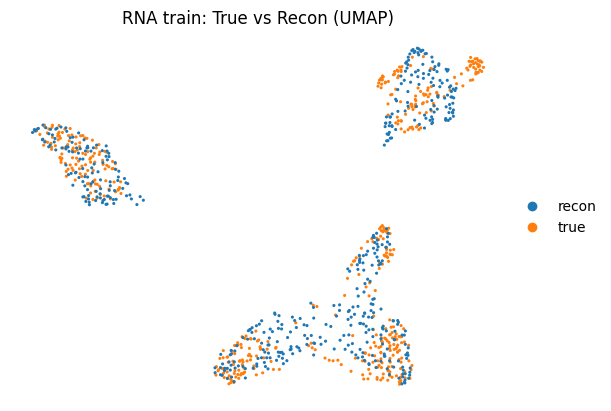

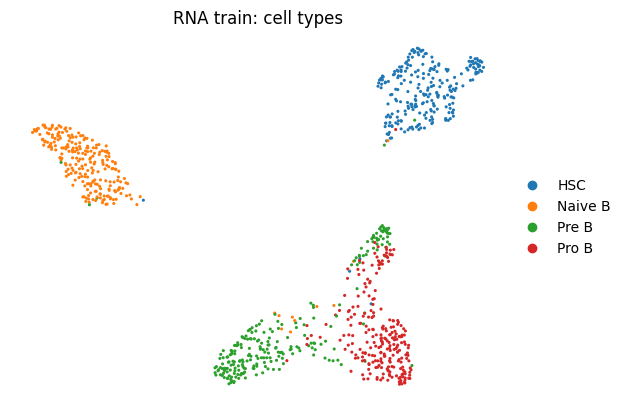

In [106]:
# 1) 得到重建（训练集）
rna_ref_vae.eval()
with torch.no_grad():
    X_true = Xn_train  # (N_train, F) —— 已在预处理阶段按HVG裁剪过
    X_hat  = rna_ref_vae(torch.from_numpy(X_true).float().to(device))[0].cpu().numpy()

# 2) 组合成一个 AnnData，打标签（真值 / 重建）
X_all = np.vstack([X_true, X_hat])               # (2N, F)
obs = {}
obs["dataset"] = (["true"] * len(X_true)) + (["recon"] * len(X_hat))

# 用“全局映射”把 yn_train 还原为字符串，确保与其它模块一致
celltype_train = np.array([global_id2label[i] for i in yn_train], dtype=str)
obs["cell_type"] = list(celltype_train) + list(celltype_train)

ad = sc.AnnData(X_all)
for k, v in obs.items():
    ad.obs[k] = v

# var_names：直接用预处理里对应到 Xn(HVG裁剪后) 的基因名
ad.var_names = gene_names_rna

# 3) UMAP（不再 scale，防止把幅度关系打散）
sc.pp.pca(ad, n_comps=30, random_state=0)
sc.pp.neighbors(ad, n_neighbors=30, n_pcs=30, random_state=0)
sc.tl.umap(ad, min_dist=0.3, random_state=0)

# 4) 画图：按来源（真值/重建）与按 cell_type
sc.pl.umap(ad, color="dataset", title="RNA train: True vs Recon (UMAP)", size=20, frameon=False)
sc.pl.umap(ad, color="cell_type", title="RNA train: cell types", size=20, frameon=False, legend_loc='right margin')


[cell-wise corr]  mean=0.676  median=0.684  min=0.363  max=0.834


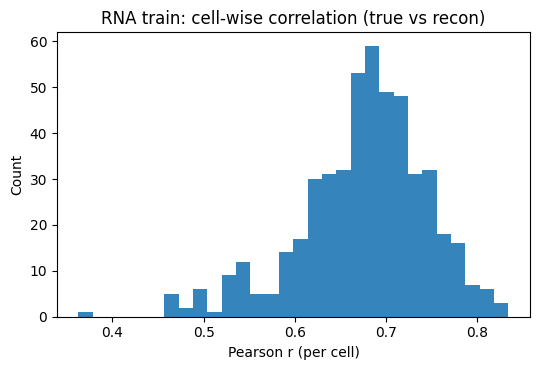

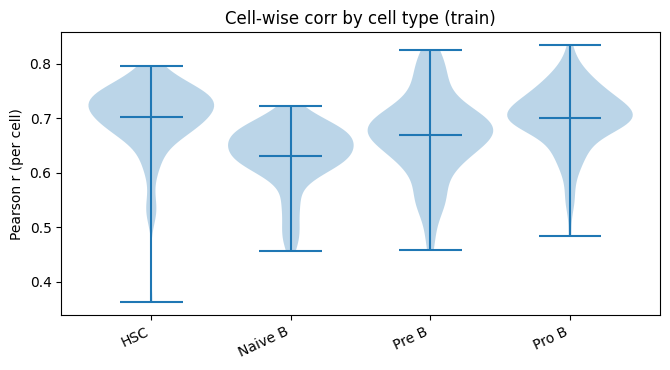

In [107]:
# ===== cell-wise correlation（true vs recon）=====
import numpy as np
import matplotlib.pyplot as plt

def _safe_corr_rows(A, B, eps=1e-8):
    """
    对矩阵每一行计算 Pearson r，返回 shape=(N,)。
    A,B: (N, F)
    """
    A = A - A.mean(axis=1, keepdims=True)
    B = B - B.mean(axis=1, keepdims=True)
    num = np.sum(A * B, axis=1)
    den = np.sqrt(np.sum(A*A, axis=1) * np.sum(B*B, axis=1)) + eps
    return num / den

# 1) 逐细胞 r
per_cell_r = _safe_corr_rows(X_true, X_hat)

print(f"[cell-wise corr]  mean={per_cell_r.mean():.3f}  median={np.median(per_cell_r):.3f}  "
      f"min={per_cell_r.min():.3f}  max={per_cell_r.max():.3f}")

# 2) 直方图
plt.figure(figsize=(5.5,3.8))
plt.hist(per_cell_r, bins=30, alpha=0.9)
plt.xlabel("Pearson r (per cell)")
plt.ylabel("Count")
plt.title("RNA train: cell-wise correlation (true vs recon)")
plt.tight_layout()
plt.show()

# 3)（可选）按 cell_type 查看分布（箱线/小提琴）
show_by_type = True
if show_by_type:
    ct = np.asarray(celltype_train)  # 和 X_true 顺序一致
    groups = np.unique(ct)
    data = [per_cell_r[ct == g] for g in groups]

    plt.figure(figsize=(6.8,3.8))
    plt.violinplot(data, showmeans=True, widths=0.9)
    plt.xticks(range(1, len(groups)+1), groups, rotation=25, ha='right')
    plt.ylabel("Pearson r (per cell)")
    plt.title("Cell-wise corr by cell type (train)")
    plt.tight_layout()
    plt.show()


In [108]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch

# 复用你已有的重建函数名；如果你叫 _reconstruct_fast，就把下一行的函数名改成它
@torch.no_grad()
def _reconstruct_fast(vae, X, device=None, batch=512):
    device = device or (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
    vae.eval()
    outs = []
    for i in range(0, len(X), batch):
        xb = torch.from_numpy(X[i:i+batch]).float().to(device)
        outs.append(vae(xb)[0].detach().cpu().numpy())
    return np.vstack(outs)

def _bulk_profile(X, how="sum", eps=1e-12, normalize=False, rectify="none"):
    """
    how: 'sum' or 'mean'
    normalize=True -> 归一化为比例（适合 count/pseudo-bulk）; scaled 空间建议 False
    rectify: 'none' | 'softplus' | 'clip' | 'shift' 处理负值
    """
    X = np.asarray(X, dtype=np.float64)
    if rectify == "softplus":
        X = np.log1p(np.exp(X))
    elif rectify == "clip":
        X = np.clip(X, 0, None)
    elif rectify == "shift":
        mn = X.min(axis=0, keepdims=True)
        X = X - np.minimum(mn, 0.0)
    elif rectify == "none":
        pass
    else:
        raise ValueError("rectify must be one of ['none','softplus','clip','shift']")

    g = X.sum(axis=0) if how == "sum" else X.mean(axis=0)
    if normalize:
        g = g / (g.sum() + eps)
    return np.asarray(g, dtype=np.float64)

def eval_bulk_correlation_refvae(
    name, vae, X, *,
    device=None,
    gene_names=None,        # 直接传预处理后的 gene_names_rna（与 X 匹配）
    how="sum",
    per_group=False,
    adata=None, indices=None, group_key="cell_type",
    rectify="none",
    normalize=False,        # scaled/z-score 空间：默认 False
    per_group_plot="scatter"
):
    device = device or (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

    # 1) 重建（与 X 维度一致；不要再做 HVG 掩码）
    X_hat = _reconstruct_fast(vae, X, device=device)

    # 2) 聚合 & 相关（全特征 = 预处理时的特征子集）
    orig_all  = _bulk_profile(X,     how=how, rectify=rectify, normalize=normalize)
    recon_all = _bulk_profile(X_hat, how=how, rectify=rectify, normalize=normalize)
    r_all = float(np.corrcoef(orig_all, recon_all)[0, 1])

    # 3) 可视化：排序散点（单图）
    def _plot_scatter(orig, recon, title, xlabel='Feature Index',
                      ylabel='Aggregate (proportion)' if normalize else 'Aggregate'):
        order = np.argsort(orig)
        plt.scatter(np.arange(len(orig)), orig[order], s=1, label="Original")
        plt.scatter(np.arange(len(recon)), recon[order], s=1, label="Reconstructed")
        plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)

    plt.figure(figsize=(6,5))
    _plot_scatter(orig_all, recon_all, f"{name}  (r={r_all:.3f})")
    plt.legend(markerscale=8)
    plt.tight_layout(); plt.show()

    out = {"r_all": r_all, "orig_all": orig_all, "recon_all": recon_all}

    # 4) （可选）按 group 评估
    if per_group:
        assert (adata is not None) and (indices is not None), "per_group=True 需要 adata 与 indices"
        group_labels = np.asarray(adata.obs[group_key])[indices]
        groups = np.unique(group_labels)
        per_grp = {}
        per_grp_aggr = {}

        for g in groups:
            idx = np.where(group_labels == g)[0]
            if len(idx) < 2:
                continue
            o = _bulk_profile(X[idx],     how=how, rectify=rectify, normalize=normalize)
            h = _bulk_profile(X_hat[idx], how=how, rectify=rectify, normalize=normalize)
            per_grp[g] = float(np.corrcoef(o, h)[0, 1])
            per_grp_aggr[g] = (o, h)

        if per_grp_aggr:
            C = len(per_grp_aggr)
            ncols = min(4, C)
            nrows = math.ceil(C / ncols)
            plt.figure(figsize=(4*ncols, 3.2*nrows))
            for k, (g, (o, h)) in enumerate(per_grp_aggr.items(), start=1):
                plt.subplot(nrows, ncols, k)
                order = np.argsort(o)
                plt.scatter(np.arange(len(o)), o[order], s=1, label="Original")
                plt.scatter(np.arange(len(h)), h[order], s=1, label="Reconstructed")
                plt.title(f"{g}  (r={per_grp[g]:.3f})", fontsize=10)
                if k == 1:
                    plt.legend(markerscale=8, fontsize=8)
                plt.xlabel('Feature Index', fontsize=9)
                plt.ylabel('Proportion' if normalize else 'Aggregate', fontsize=9)
            plt.tight_layout(); plt.show()

        if per_group_plot == "bar" and per_grp:
            plt.figure(figsize=(6,3.5))
            keys = list(per_grp.keys()); vals = [per_grp[k] for k in keys]
            plt.bar(range(len(keys)), vals)
            plt.xticks(range(len(keys)), keys, rotation=30, ha='right')
            plt.ylim(-0.1, 1.0)
            plt.ylabel("Pearson r"); plt.title(f"{name} per-{group_key} corr")
            plt.tight_layout(); plt.show()

        out["per_group_r"] = per_grp

    return out


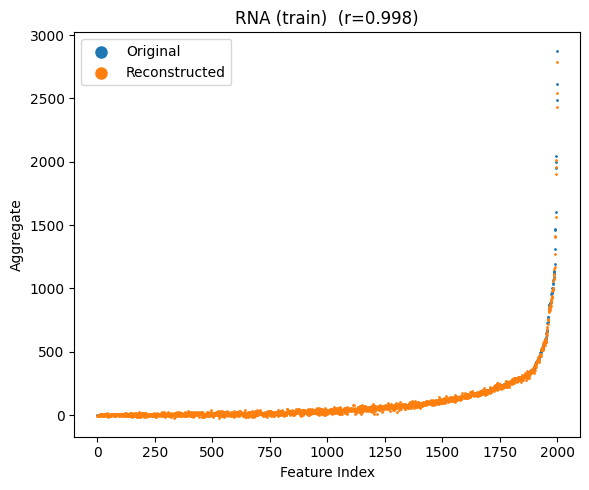

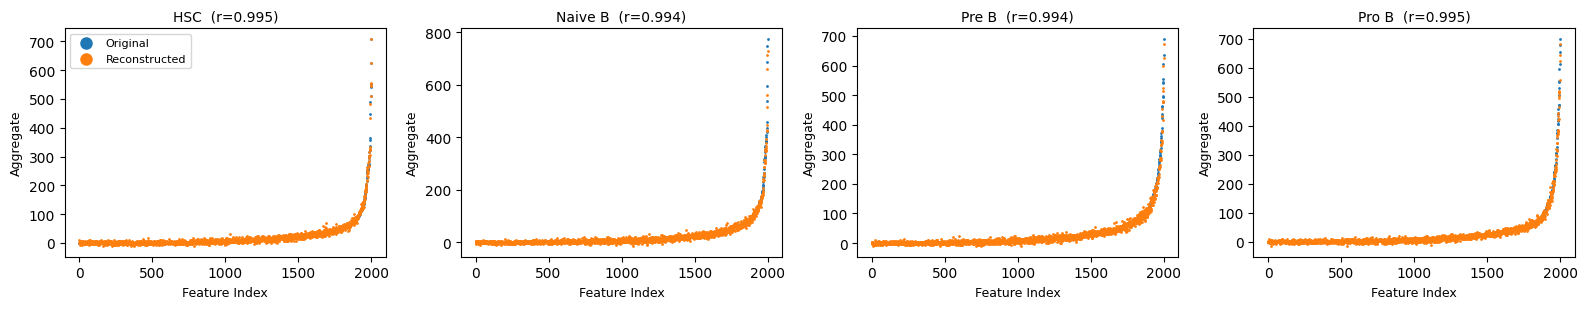

Train r_all: 0.998186549963405
Train per-group r: {'HSC': 0.9945828317209474, 'Naive B': 0.994231941414179, 'Pre B': 0.9939832838617797, 'Pro B': 0.9951525767364597}


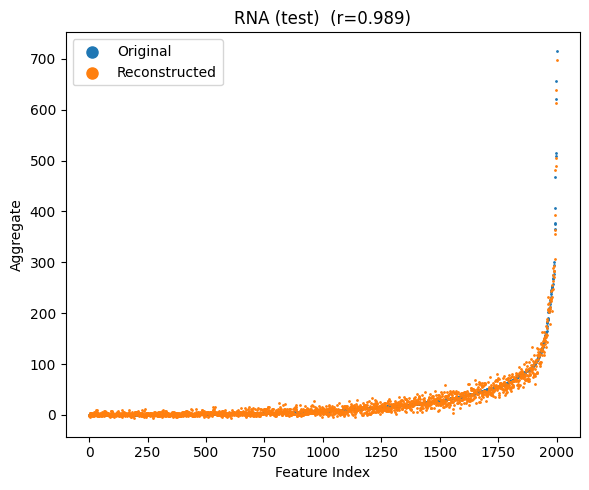

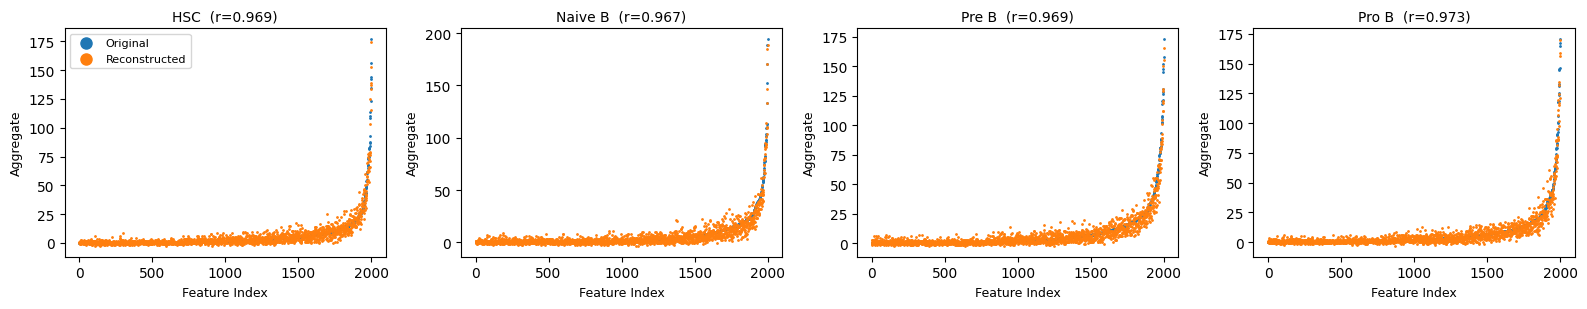

Test r_all: 0.9893832446399271
Test per-group r: {'HSC': 0.9687994010617598, 'Naive B': 0.9667379407976748, 'Pre B': 0.9686907993663514, 'Pro B': 0.9730944230796705}


In [109]:
# —— 训练集重建相关（看拟合能力）——
res_bulk_train = eval_bulk_correlation_refvae(
    name="RNA (train)",
    vae=rna_ref_vae,
    X=Xn_train,           # 直接用预处理得到的训练矩阵
    device=device,
    gene_names=gene_names_rna,   # 可选；与 Xn_train 对齐
    how="sum",
    per_group=True,       # 分 cell_type 画图
    adata=adata_n,
    indices=n_train_idx,  # ★ 用训练集索引（注意是 n_train_idx）
    group_key="cell_type",
    rectify="none",
    normalize=False       # 若是 scaled/z-score 空间，建议 False
)
print("Train r_all:", res_bulk_train["r_all"])
print("Train per-group r:", res_bulk_train.get("per_group_r", {}))

# —— 测试集重建相关（看泛化）——
res_bulk_test = eval_bulk_correlation_refvae(
    name="RNA (test)",
    vae=rna_ref_vae,
    X=Xn_test,
    device=device,
    gene_names=gene_names_rna,   # 与 Xn_test 对齐
    how="sum",
    per_group=True,
    adata=adata_n,
    indices=n_test_idx,   # ★ 测试集索引（注意是 n_test_idx）
    group_key="cell_type",
    rectify="none",
    normalize=False
)
print("Test r_all:", res_bulk_test["r_all"])
print("Test per-group r:", res_bulk_test.get("per_group_r", {}))


In [112]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from itertools import cycle

# 依赖：你前面已经定义过的模块/函数：
# StandardEncoder, StandardDecoder, VAE, Discriminator, old_vae_loss, discrim_loss
# 若不在当前环境，请先粘贴我们之前整理过的“基础模型代码”。

# ----------------------
# 构建 Raman 侧 AAE 模型
# ----------------------
def build_raman_aae(input_dim, latent_dim=128, hidden_dim=2048, latent_norm='batch'):
  """
  返回:
    - raman_vae: VAE(encoder, decoder)，is_vae=False（与文献一致）
    - discrim : 判别器，输出2个logits（source/target）
  """
  raman_vae = VAE(
      encoder=StandardEncoder(input_dim, latent_dim, hidden_dim=hidden_dim),
      decoder=StandardDecoder(input_dim, latent_dim, hidden_dim=hidden_dim, no_final_relu=True),
      is_vae=False,
      latent_norm=latent_norm,
  )
  discrim = Discriminator(latent_dim=latent_dim, spectral=True, end_dim=2)
  return raman_vae, discrim


# ----------------------
# 训练一步：判别器
# ----------------------
def d_step(discrim, ref_z, ram_z, opt_d, label_smooth=0.1):
  discrim.train()
  opt_d.zero_grad()

  # one-hot + label smoothing
  y_ref = torch.tensor([1.0 - label_smooth, 0.0 + label_smooth], device=ref_z.device)
  y_ram = torch.tensor([0.0 + label_smooth, 1.0 - label_smooth], device=ref_z.device)
  y = torch.cat([y_ref.expand(ref_z.size(0), 2),
                  y_ram.expand(ram_z.size(0), 2)], dim=0)

  logits = discrim(torch.cat([ref_z.detach(), ram_z.detach()], dim=0))
  loss = F.binary_cross_entropy_with_logits(logits, y)
  loss.backward()
  opt_d.step()
  return float(loss.item())


# ----------------------
# 训练一步：生成器（Raman VAE）
# ----------------------
def g_step(raman_vae, discrim, xb_raman, opt_g,
        recon_weight=1.0, adv_weight=0.3,
        aux_clf=None, y_raman=None, aux_weight=50.0):
  raman_vae.train()
  discrim.eval()
  opt_g.zero_grad()

  recon, mean, logvar, z = raman_vae(xb_raman)  # is_vae=False -> mean/logvar未用，仅接口保持
  # 自重构损失（MSE）
  recon_loss = F.mse_loss(recon, xb_raman)

  # 对抗损失：让 Raman latent 被判为“source”(=ref)
  target = torch.tensor([1.0, 0.0], device=xb_raman.device).expand(z.size(0), 2)
  adv_loss = F.binary_cross_entropy_with_logits(discrim(z), target)

  loss = recon_weight * recon_loss + adv_weight * adv_loss

  # 可选：细胞类型辅助损失（把 ref 上训练好的分类器接到 Raman latent）
  aux = None
  if (aux_clf is not None) and (y_raman is not None):
    aux_clf.eval()
    logits_ct = aux_clf(z)
    aux = F.cross_entropy(logits_ct, y_raman)
    loss = loss + aux_weight * aux

  loss.backward()
  opt_g.step()
  return {
      "recon": float(recon_loss.item()),
      "adv": float(adv_loss.item()),
      "aux": (float(aux.item()) if aux is not None else None),
  }


# -------------------------------------------------
# 主函数：训练 Raman-AAF，把 Raman 对齐到 ref_vae 的潜空间
# -------------------------------------------------
def train_raman_aae(
    *,
    ref_vae,                     # 已训练好的 RNA ref_vae
    ref_loader,                  # 直接传你已有的 rna_train_loader
    ram_loader,                  # 直接传你已有的 raman_train_loader（含 (X,y) 或 (X,)）
    latent_dim=LATENT_DIM,
    hidden_dim=HIDDEN_DIM,
    lr_g=1e-4,
    lr_d=1e-3,
    recon_weight=1.0,
    adv_weight=1e-2,
    aux_weight=50.0,
    label_smooth=0.1,
    use_latent_norm='batch',
    epochs=EPOCHS,
    device=None,
    pretrained_aux_clf=None,     # 传你已经训练好的 clf（teacher）；不想用就 None
    rna_label2id=None,           # 可选：RNA 的 label->id 映射（保证对齐）
    ram_id2label=None,           # 可选：Raman 的 id->label 映射（保证对齐）
):
    """
    只做训练，不创建任何 DataLoader。ref_loader/ram_loader 均来自你的预处理。
    如果要用 teacher 监督且两侧编码不同，传入 rna_label2id 与 ram_id2label 来对齐。
    """
    device = device or (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
    ref_vae = ref_vae.to(device).eval()
    for p in ref_vae.parameters(): p.requires_grad = False

    # 从 ram_loader 第一批推断输入维度
    first_batch = next(iter(ram_loader))
    xb0 = first_batch[0] if isinstance(first_batch, (tuple, list)) else first_batch
    input_dim = xb0.shape[1]

    # 构建 Raman 侧 AAE（只构建模型，不碰你的 loaders）
    raman_vae, discrim = build_raman_aae(input_dim, latent_dim, hidden_dim, latent_norm=use_latent_norm)
    raman_vae = raman_vae.to(device)
    discrim   = discrim.to(device)

    opt_g = torch.optim.Adam(raman_vae.parameters(), lr=lr_g)
    opt_d = torch.optim.Adam(discrim.parameters(),   lr=lr_d)

    # teacher（冻结）
    aux_clf = None
    if pretrained_aux_clf is not None:
        aux_clf = pretrained_aux_clf.to(device).eval()
        for p in aux_clf.parameters(): p.requires_grad = False

    print("Begin Raman AAE training ...")
    logs = []

    # 用 cycle(ref_loader) 保证每个 Raman batch 都能配到一个 RNA batch
    ref_iter = None
    for ep in range(1, epochs+1):
      ep_d = ep_r = ep_a = ep_aux = 0.0
      nb = 0

      if ref_iter is None:
          ref_iter = cycle(ref_loader)

      for batch_r in ram_loader:
        # Raman batch: 兼容 (X,) 或 (X,y)
        if isinstance(batch_r, (tuple, list)) and len(batch_r) == 2:
          xb_r, yb = batch_r
          xb_r = xb_r.to(device)
          yb = yb.to(device)
        else:
          xb_r = batch_r[0].to(device) if isinstance(batch_r, (tuple, list)) else batch_r.to(device)
          yb = None

        # RNA batch（只要 X，不需要 y）
        (xb_ref, *_) = next(ref_iter)
        xb_ref = xb_ref.to(device)

        # -------- 判别器步：用 mean latent（+BN），且 eval() 拿值 --------
        with torch.no_grad():
          ref_vae.eval()
          m_ref, _ = ref_vae.encoder(xb_ref)
          if getattr(ref_vae, "use_latent_norm", False):
            m_ref = ref_vae.latent_normalizer(m_ref)

          raman_vae.eval()
          m_ram, _ = raman_vae.encoder(xb_r)
          if getattr(raman_vae, "use_latent_norm", False):
            m_ram = raman_vae.latent_normalizer(m_ram)

        turn_on_model(discrim)
        dloss = d_step(discrim, m_ref, m_ram, opt_d, label_smooth=label_smooth)
        turn_off_model(discrim)

        # -------- 生成器步：Raman VAE（重构 + 对抗 + 可选 teacher 监督）--------
        # 若需要把 Raman 的 y 按 RNA 的 classes 对齐，这里重映射
        y_for_aux = None
        if (yb is not None) and (aux_clf is not None) and (ram_id2label is not None) and (rna_label2id is not None):
          # yb: int(ids in Raman) -> str(label) -> int(id in RNA)
          y_np = yb.detach().cpu().numpy()
          y_map = [rna_label2id[ram_id2label[int(t)]] for t in y_np]
          y_for_aux = torch.tensor(y_map, dtype=torch.long, device=device)
        else:
          y_for_aux = yb  # 已经统一过的就直接用

        gout = g_step(
          raman_vae, discrim, xb_r, opt_g,
          recon_weight=recon_weight, adv_weight=adv_weight,
          aux_clf=aux_clf, y_raman=y_for_aux, aux_weight=aux_weight
        )

        turn_on_model(discrim)

        # 记录
        ep_d   += dloss
        ep_r   += gout["recon"]
        ep_a   += gout["adv"]
        ep_aux += (gout["aux"] if gout["aux"] is not None else 0.0)
        nb     += 1

      msg = f"[{ep:03d}] D:{ep_d/nb:.4f}  Recon:{ep_r/nb:.5f}  Adv:{ep_a/nb:.5f}"
      if aux_clf is not None:
        msg += f"  Aux:{ep_aux/nb:.5f}"
      print(msg)

      logs.append({
          "epoch": ep, "D": ep_d/nb, "Recon": ep_r/nb, "Adv": ep_a/nb,
          "Aux": (ep_aux/nb if aux_clf is not None else None)
      })

    # 训练完构建 transfer_vae：encoder=raman, decoder=ref
    transfer_vae = VAE(
    encoder=raman_vae.encoder,
    decoder=ref_vae.decoder,
    is_vae=False,
    latent_norm=use_latent_norm,
    ).to(device).eval()

    return raman_vae.eval(), discrim.eval(), transfer_vae, logs



In [122]:
# 直接用你预处理阶段产出的 loader 与映射
ref_loader  = rna_train_loader
ram_loader  = raman_train_loader
teacher_clf = clf  # 你前面在 RNA latent 上训练好的分类器

# 注意：把映射传进来，保证 Raman 标签对齐到 RNA 的 classes
raman_vae, D, transfer_raman2rna, logs = train_raman_aae(
    ref_vae=rna_ref_vae,
    ref_loader=ref_loader,
    ram_loader=ram_loader,
    latent_dim=LATENT_DIM,
    hidden_dim=HIDDEN_DIM,
    lr_g=1e-4, lr_d=1e-3,
    recon_weight=10, adv_weight=1e-3,
    aux_weight=1,
    label_smooth=0.1,
    use_latent_norm='batch',
    epochs=20,
    pretrained_aux_clf=teacher_clf,
    rna_label2id=n_label2id,
    ram_id2label=r_id2label,
)


Begin Raman AAE training ...
[001] D:0.6517  Recon:0.74128  Adv:0.55350  Aux:0.57758
[002] D:0.5941  Recon:0.52261  Adv:0.81294  Aux:0.19915
[003] D:0.4980  Recon:0.48306  Adv:1.15451  Aux:0.20593
[004] D:0.4601  Recon:0.45583  Adv:1.28960  Aux:0.14453
[005] D:0.4420  Recon:0.42702  Adv:1.34928  Aux:0.05880
[006] D:0.4216  Recon:0.39893  Adv:1.44641  Aux:0.03519
[007] D:0.4204  Recon:0.38529  Adv:1.44570  Aux:0.06245
[008] D:0.4121  Recon:0.35494  Adv:1.46553  Aux:0.02834
[009] D:0.4093  Recon:0.33361  Adv:1.51024  Aux:0.03368
[010] D:0.4136  Recon:0.31550  Adv:1.46296  Aux:0.04760
[011] D:0.4048  Recon:0.30215  Adv:1.53351  Aux:0.04199
[012] D:0.4132  Recon:0.31894  Adv:1.45418  Aux:0.05160
[013] D:0.4039  Recon:0.31814  Adv:1.50704  Aux:0.05812
[014] D:0.4014  Recon:0.30616  Adv:1.49905  Aux:0.02933
[015] D:0.4001  Recon:0.28451  Adv:1.61915  Aux:0.01901
[016] D:0.4082  Recon:0.27224  Adv:1.54797  Aux:0.03323
[017] D:0.4037  Recon:0.24495  Adv:1.50067  Aux:0.01534
[018] D:0.3990  Rec

你这几列损失的含义可以这样理解：

---

**1. `D`（Discriminator loss，判别器损失）**

* 来自 `d_step()`
* 判别器要区分 **RNA latent（source）** 和 **Raman latent（target）**。
* 损失越低，说明它分得越准；越高说明它分不出来（或被生成器欺骗成功）。
* 训练开始时 D 比较高（0.64），说明判别器还没学会区分。随着训练，D 降到 0.39 左右，表示判别器能在一定程度上分辨两个模态的 latent。
* 但是在 AAE 里，我们并不希望判别器特别强，而是希望它和生成器处于博弈平衡。

---

**2. `Recon`（Reconstruction loss，自重构损失）**

* 来自 `g_step()` 的 `recon_loss = F.mse_loss(recon, xb_raman)`。
* 衡量 Raman VAE 在自身输入空间的重构能力（这里是 MSE）。
* 数值越低说明 Raman 编码器+解码器在自身模态上的重建越好。
* 你这里从 0.78 降到 0.42，说明 Raman 模型在逐渐学会重构自己的输入。

---

**3. `Adv`（Adversarial loss，对抗损失）**

* 来自 `g_step()` 的 `adv_loss`，生成器希望自己的 latent 被判别器误判为 **RNA latent**（source）。
* 数值越低表示生成器更成功地欺骗了判别器（latent 对齐得更好）。
* 你这里 Adv 从 0.68 升到 1.59，说明判别器在后期逐渐变强（生成器的对抗目标更难达成）。
* 在 AAE 中，Adv 波动较大是正常的，因为判别器和生成器在相互博弈。

---

**4. `Aux`（Auxiliary classification loss，辅助分类损失）**

* 这是可选的 teacher 分类器损失（cell type 分类的交叉熵）。
* 来自 `g_step()` 中的 `aux = F.cross_entropy(logits_ct, y_raman)`。
* 低说明 Raman latent 经过对齐后，在 RNA 训练好的分类器下能准确预测细胞类型。
* 你这里 Aux 从 0.83 快速降到 \~0.02，说明 Raman latent 的细胞类型信息被保留且对齐得不错。

---

📌 **总结**

* `D`：判别器分辨力
* `Recon`：Raman 模型自重构精度
* `Adv`：Raman latent 与 RNA latent 的对齐程度（生成器对抗目标）
* `Aux`：Raman latent 的细胞类型预测精度（可选）

从你这个趋势看：

* 自重构 (`Recon`) 明显下降 ✅
* 细胞类型保持很好 (`Aux` 快速下降) ✅
* 对抗损失 (`Adv`) 升高，说明判别器压制生成器，这可能会影响对齐效果 ❗
  → 这时候可以适当 **调低判别器学习率（lr\_d）或 Adv 权重**，让生成器有更多空间去对齐 latent。

---

如果你愿意，我可以帮你画一张 **AAE 损失曲线+解释的趋势图**，更直观看这几个 loss 的动态关系。这样你就能判断博弈是否平衡。
你要我帮你画吗？


/tmp/ipython-input-343440547.py:36: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  together_tr = adata_rna_rec.concatenate(
/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1774: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1774: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


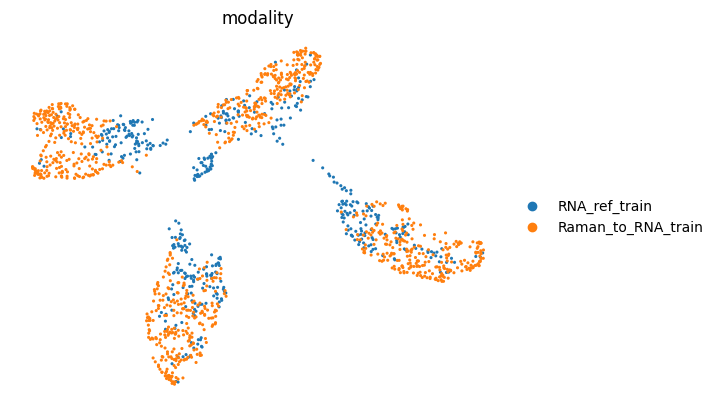

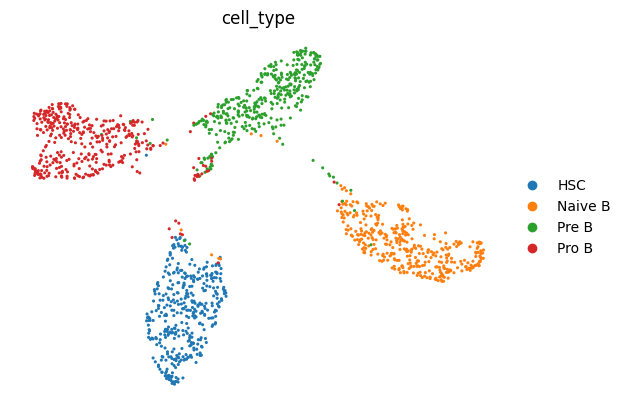

In [123]:
# ---- 只取【训练集】 ----
X_ref_train   = Xn_train          # RNA 训练子集（预处理里已有）
X_raman_train = Xr_train          # Raman 训练子集（预处理里已有）

rna_obs_tr   = adata_n.obs.iloc[n_train_idx].copy()   # ⚠ 与预处理保持同名 n_train_idx
raman_obs_tr = adata_r.obs.iloc[r_train_idx].copy()

# ---- 重建到 RNA 空间 ----
recon_rna_tr    = _reconstruct_fast(rna_ref_vae,        X_ref_train,   device=device)
recon_raman2_tr = _reconstruct_fast(transfer_raman2rna, X_raman_train, device=device)

adata_rna_rec   = sc.AnnData(recon_rna_tr)
adata_raman_rec = sc.AnnData(recon_raman2_tr)

# 补 var_names（尤其用了 HVG 的场景）
if USE_RNA_HVG and ('highly_variable' in adata_n.var.columns):
    hvg_mask = adata_n.var['highly_variable'].values
    gene_names_used = np.array(adata_n.var_names)[hvg_mask]
else:
    gene_names_used = np.array(adata_n.var_names)

adata_rna_rec.var_names   = gene_names_used
adata_raman_rec.var_names = gene_names_used  # 两者对齐，后面 concatenate 不会乱

# 继承常用 obs
for col in ("cell_type", "leiden", "batch"):
    if col in rna_obs_tr.columns:
        adata_rna_rec.obs[col] = rna_obs_tr[col].values
    if col in raman_obs_tr.columns:
        adata_raman_rec.obs[col] = raman_obs_tr[col].values

adata_rna_rec.obs["modality"]   = "RNA_ref_train"
adata_raman_rec.obs["modality"] = "Raman_to_RNA_train"

# 拼接（新版 scanpy 推荐 sc.concat，但 .concatenate 也可用）
together_tr = adata_rna_rec.concatenate(
    adata_raman_rec,
    join="inner",
    batch_key="concat_batch",
    index_unique=None
)

# ---- UMAP ----
sc.pp.pca(together_tr, n_comps=30)            # ← 用 pp.pca
sc.pp.neighbors(together_tr, n_neighbors=30, n_pcs=30)
sc.tl.umap(together_tr, min_dist=0.3)

sc.pl.umap(together_tr, color=["modality"], size=20, frameon=False)
if "cell_type" in together_tr.obs.columns:
    sc.pl.umap(together_tr, color=["cell_type"], size=20, frameon=False)

/tmp/ipython-input-2717978532.py:53: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  together = adata_rna_all.concatenate(
/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1774: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1774: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


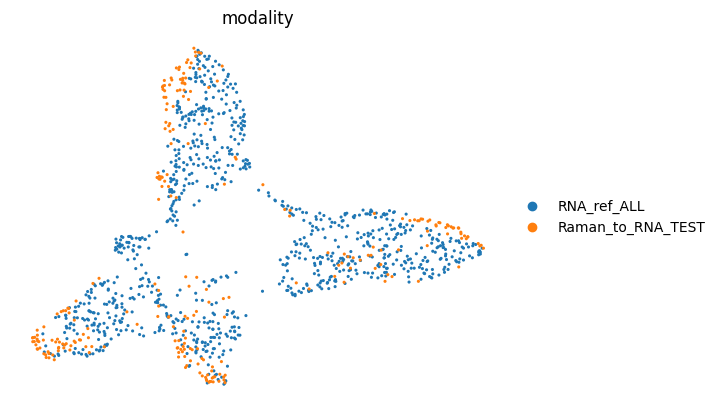

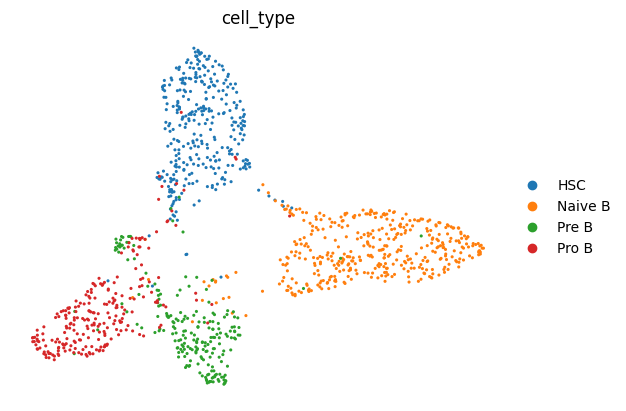

In [124]:
import numpy as np
import scanpy as sc
import torch

# 复用你之前的重建函数；若已定义则不会重复
if '_reconstruct_fast' not in globals():
    @torch.no_grad()
    def _reconstruct_fast(vae, X, device=None, batch=512):
        device = device or (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
        vae = vae.to(device).eval()
        outs = []
        for i in range(0, len(X), batch):
            xb = torch.from_numpy(X[i:i+batch]).float().to(device)
            outs.append(vae(xb)[0].cpu().numpy())
        return np.vstack(outs)

# 1) 准备 RNA 基因名（与训练维度一致，考虑 HVG）
if USE_RNA_HVG and ('highly_variable' in adata_n.var.columns):
    hvg_mask = adata_n.var['highly_variable'].values
    gene_names_used = np.array(adata_n.var_names)[hvg_mask]
else:
    hvg_mask = None
    gene_names_used = np.array(adata_n.var_names)

# 2) 重建全部 RNA（保持和 transfer 后同空间、同解码器的尺度）
X_rna_all_recon = _reconstruct_fast(rna_ref_vae, Xn, device=device)   # (N_rna_all, F_used)

# 3) 将 Raman 测试集转到 RNA 空间
X_raman_test2rna = _reconstruct_fast(transfer_raman2rna, Xr_test, device=device)  # (N_raman_test, F_used)

# 4) 组装 AnnData，并打上元信息
adata_rna_all = sc.AnnData(X_rna_all_recon)
adata_raman_te = sc.AnnData(X_raman_test2rna)

# 统一 var_names，避免 concatenate 出问题
adata_rna_all.var_names  = gene_names_used
adata_raman_te.var_names = gene_names_used

# 继承 obs
rna_obs_all   = adata_n.obs.copy()
raman_obs_te  = adata_r.obs.iloc[r_test_idx].copy()

for col in ("cell_type", "leiden", "batch"):
    if col in rna_obs_all.columns:
        adata_rna_all.obs[col] = rna_obs_all[col].values
    if col in raman_obs_te.columns:
        adata_raman_te.obs[col] = raman_obs_te[col].values

adata_rna_all.obs["modality"]  = "RNA_ref_ALL"
adata_raman_te.obs["modality"] = "Raman_to_RNA_TEST"

# 5) 合并并绘制 UMAP
together = adata_rna_all.concatenate(
    adata_raman_te,
    join="inner",
    batch_key="concat_batch",
    index_unique=None
)

sc.pp.pca(together, n_comps=30)
sc.pp.neighbors(together, n_neighbors=30, n_pcs=30)
sc.tl.umap(together, min_dist=0.3)

sc.pl.umap(together, color=["modality"], size=20, frameon=False)
if "cell_type" in together.obs.columns:
    sc.pl.umap(together, color=["cell_type"], size=20, frameon=False, legend_loc='right margin')
